In [1]:
## importing all the neccessary libraries
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [2]:
#  Our model is depend on tensorflow ver.1x thats why we import tensorflow 1x
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [3]:
## downloaded the deeplab segmentation model from github
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  # INPUT_SIZE = 1024
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    # target_size = (width, height)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

## labels for the image
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


In [4]:
## downloading the moblienetv2 from tensorflow model zoo
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')
## loading the deeplab model 
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [7]:
# this particular function runs the visualization
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try: 
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  # running the deeplab'models run fuction
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

In [8]:
# this particular line of code is for just connecting to google drive where's my image is located
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


running deeplab on image
247 204
Resize Ratio - 2.076923076923077
(513, 423)


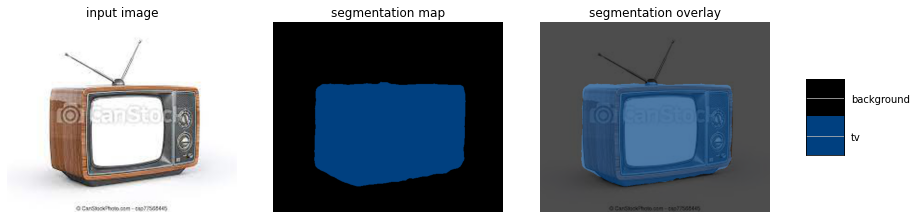

In [9]:
#giving the image path 
IMAGE_NAME = '/content/drive/MyDrive/tv.jpeg'
# Calling the run_visualization function
resized_im, seg_map = run_visualization()

In [10]:
## labels names for our image's(this labels is present in coco dataset)
LABEL_NAMES

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

In [11]:
## checking the length of our labels
len(LABEL_NAMES)

21

In [12]:
# tv label is located at 20th index
LABEL_NAMES[20]

'tv'

# Convert PIL Image to Numpy

In [13]:
## print the type of resized image
print(type(resized_im))
## convert image into numpy images
numpy_image = np.array(resized_im) 

<class 'PIL.Image.Image'>


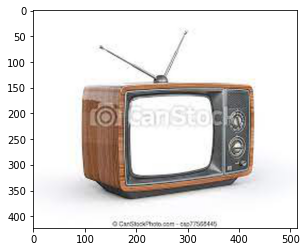

In [14]:
# visualize our numpy image 
plt.imshow(numpy_image)

# Seperate TV & Not TV classes using Segmap

In [15]:
# we create the copy of the numpy image because that any changes made to a copy of object do not reflect in the original image.
Tv_not_Tv_mapping = deepcopy(numpy_image)
# replacing with 0 where 20 is not present in our numpy image  
Tv_not_Tv_mapping[seg_map != 20] = 0
# replacing with 255 where 20 is presented in our numpy image
Tv_not_Tv_mapping[seg_map == 20] = 255

In [23]:
# checking the shape of image 
Tv_not_Tv_mapping.shape

(423, 513, 3)

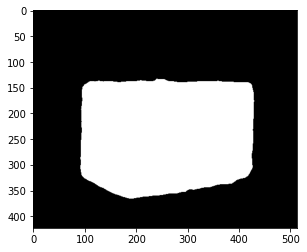

In [16]:
# showing the mapped image(where 20 is not present you see the black color and where 20 is present see's the white color )
plt.imshow(Tv_not_Tv_mapping)

In [17]:
# checking the unique value present in our image
np.unique(Tv_not_Tv_mapping)

array([  0, 255], dtype=uint8)

# Resize Tv_not_Tv_mapping to original image Resolution

In [19]:
# open the original image 
orig_imginal = Image.open(IMAGE_NAME)
# coverting the image into numpy array 
orig_imginal = np.array(orig_imginal)

In [20]:
# checking the shape of original image
orig_imginal.shape

(204, 247, 3)

In [21]:
# resize our segmeted image to same as the shape of our original image 
mapping_resized = cv2.resize(Tv_not_Tv_mapping, 
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

In [22]:
# checking the shape of our segmented image
mapping_resized.shape

(204, 247, 3)

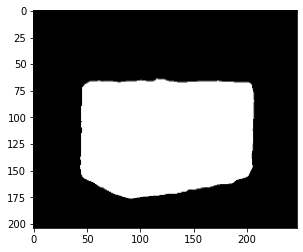

In [ ]:
# visualize the resized image
plt.imshow(mapping_resized)

In [ ]:
# cheching the unique pixal in the image 
np.unique(mapping_resized)

array([  0,   9,  15,  16,  18,  19,  20,  21,  22,  26,  28,  29,  30,
        31,  36,  39,  40,  46,  47,  50,  51,  52,  55,  56,  62,  66,
        73,  78,  81,  84,  90,  91,  92,  99, 103, 116, 118, 120, 122,
       123, 131, 132, 133, 134, 136, 138, 141, 144, 147, 149, 152, 156,
       157, 159, 166, 171, 176, 177, 178, 182, 189, 191, 196, 200, 202,
       207, 208, 216, 219, 222, 227, 228, 231, 233, 234, 235, 236, 241,
       246, 247, 248, 250, 253, 255], dtype=uint8)

In [ ]:
# color the image into gray scale
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY)
## blur the segmented image 
blurred = cv2.GaussianBlur(gray,(15,15),0)
# using the Otsu's thresholding method involves iterating through all the possible threshold values 
# and calculating a measure of spread for the pixel levels each side of the threshold,i.e.the pixels that either fall in foreground or background.
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

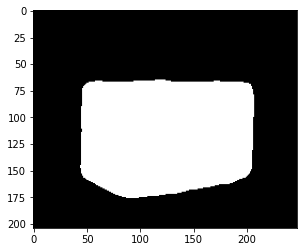

In [ ]:
# plot the thresholded image 
plt.imshow(thresholded_img, cmap="gray")

In [ ]:
# checking the no. of dimensions 
thresholded_img.ndim

2

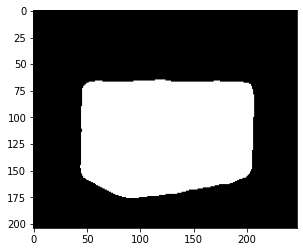

In [ ]:
# map the threshold image as gray scale
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB)
# plot the mapped the image
plt.imshow(mapping)

In [ ]:
# check the unique value in mapped image
np.unique(mapping)

array([  0, 255], dtype=uint8)

# Applying Layers

In [ ]:
# applied the blur layer in original image 
blurred_original_image = cv2.GaussianBlur(orig_imginal,
                                          (251,251), 
                                          0)

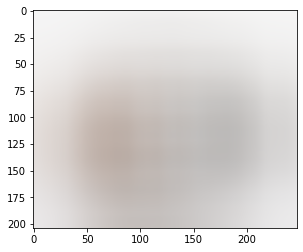

In [ ]:
# plot the blurred image
plt.imshow(blurred_original_image)

In [ ]:
## in this where mapped image is not equal to 0 in blurred image then replace with original image 
layered_image = np.where(mapping != (0,0,0), 
                         orig_imginal, 
                         blurred_original_image)

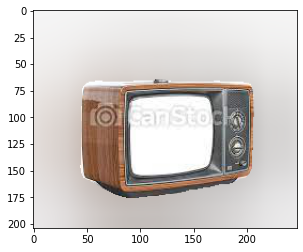

In [ ]:
plt.imshow(layered_image)